# Topic 1: AWS Data Access

---

AWS buckets can be configured to control access to the data they contain. Buckets can be configured to be **completely free and open** to users, like the [Sentinel-2 Cloud Optimized GeoTIFF](https://registry.opendata.aws/sentinel-2-l2a-cogs/) data within [Open Data on AWS](https://registry.opendata.aws/). Buckets can also be **free and open, but require authenication**, like NASA assets stored in the NASA Cumulus cloud space. Others may require user to confirm they will pay for data that is pulled out of an AWS Region (e.g., **requester pays**). Below we will walk through how to access buckets with different configurations, as well as show how to access assets via HTTPS and as s3 (when it's an option).  

## Import Required Packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests 
import boto3
import rasterio as rio                    # https://rasterio.readthedocs.io/en/latest/
from rasterio.plot import show
from rasterio.session import AWSSession
from osgeo import gdal
import rioxarray                          # https://corteva.github.io/rioxarray/stable/index.html

## Quick GDAL Detour 

#### GDAL environmental variables  

GDAL is a foundational piece of geospatial software that is leveraged by several popular open-source, and closed, geospatial software. The `rasterio` package is no exception. Rasterio leverages GDAL to, among other things, read and write raster data files, e.g., GeoTIFFs/Cloud Optimized GeoTIFFs. To read remote files, i.e., files/objects stored in the cloud, GDAL uses its [Virtual File System](https://gdal.org/user/virtual_file_systems.html) API. In a perfect world, one would be able to point a Virtual File System (there are several) at a remote data asset and have the asset retrieved, but that is not always the case. GDAL has a host of [configurations](https://gdal.org/user/configoptions.html)/environmental variables that adjust its behavior to, for example, make a req`uest more performant or to pass AWS credentials to the distribution system. Below, we'll identify the evironmental variables that will help us get our data from cloud.

### GDAL configuration option (https://gdal.org/user/configoptions.html)

- GDAL_DISABLE_READDIR_ON_OPEN
- CPL_VSIL_CURL_ALLOWED_EXTENSIONS
- AWS_NO_SIGN_REQUEST
- GDAL_MAX_RAW_BLOCK_CACHE_SIZE
- GDAL_SWATH_SIZE
- VSI_CURL_CACHE_SIZE
- GDAL_HTTP_COOKIEFILE
- GDAL_HTTP_COOKIEJAR
- GDAL_HTTP_UNSAFESSL                 # When using VPN

## Free & Open
- No AWS account required
- Access anytime and anywhere

In [2]:
fo_url = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/S/UH/2020/7/S2A_18SUH_20200729_0_L2A/B04.tif'

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 4300020.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
Overviews levels: [2, 4, 8, 16]
<class 'rasterio.io.DatasetReader'>


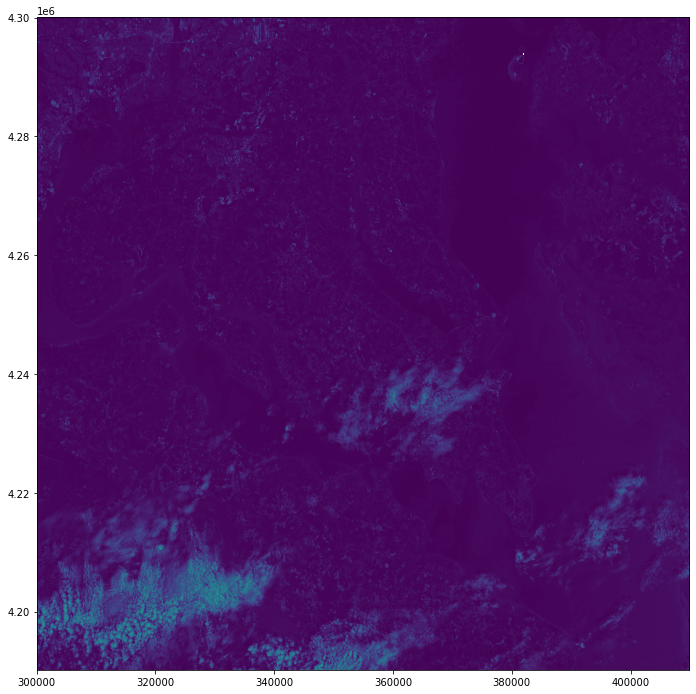

CPU times: user 7.6 s, sys: 1.79 s, total: 9.38 s
Wall time: 13.5 s


In [3]:
%%time

with rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='TRUE',    # https://rasterio.readthedocs.io/en/latest/topics/configuration.html
             AWS_NO_SIGN_REQUEST='YES',
             CPL_VSIL_CURL_ALLOWED_EXTENSIONS='tif'):
    with rio.open(fo_url) as src:
        print(src.profile)
        print(f'Overviews levels: {src.overviews(1)}')
        print(type(src))
        
        fig, ax = plt.subplots(1, figsize=(12, 12))
        show(src)

## Free & Open with Authentication
- No AWS account required
- Access anytime and anywhere
- For NASA data, authenication is done through Earthdata Login
- Must have a netrc file with proper credetials in your user directory

In [4]:
foa_url = "https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TGF.2020274T174141.v2.0/HLS.S30.T13TGF.2020274T174141.v2.0.B04.tif"

**If you do not have a [netrc](https://git.earthdata.nasa.gov/projects/LPDUR/repos/daac_data_download_python/browse) file with proper credetial in your user directory and do not set the proper GDAL environmental variables, you will get this fun/misleading error.**


**In this example we need to set `GDAL_HTTP_COOKIEFILE` and `GDAL_HTTP_COOKIEJAR`. These two configurations settings, along with the configurations we set above will allow us to access these data.** 

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 4600020.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
Overviews levels: [2, 4, 8, 16]
<class 'rasterio.io.DatasetReader'>


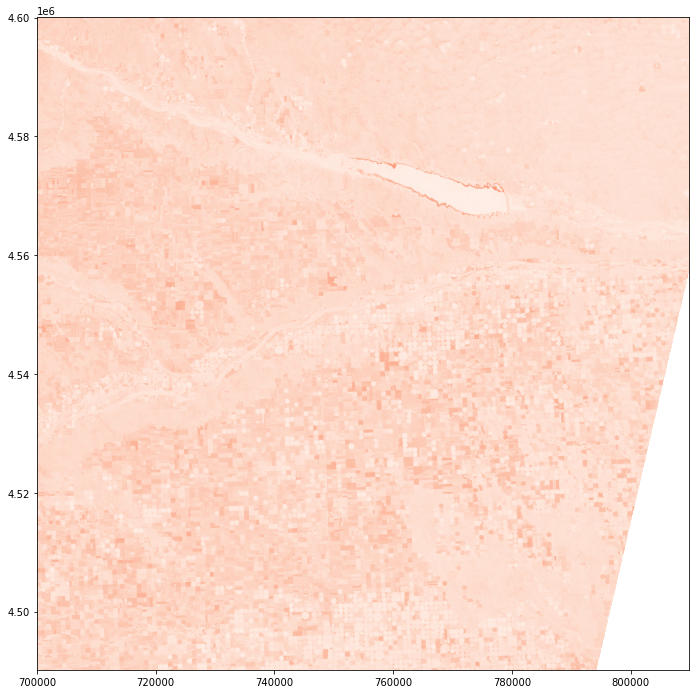

CPU times: user 1.73 s, sys: 209 ms, total: 1.94 s
Wall time: 9.26 s


In [5]:
%%time

with rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
             CPL_VSIL_CURL_ALLOWED_EXTENSIONS='tif', 
             GDAL_HTTP_COOKIEFILE='~/cookies.txt', 
             GDAL_HTTP_COOKIEJAR='~/cookies.txt'):
    with rio.open(foa_url) as src:
        print(src.profile)
        print(f'Overviews levels: {src.overviews(1)}')
        print(type(src))
        
        hls_ov_levels = src.overviews(1)                  # We'll use this later on...
        hls_proj = src.crs.to_string()                    # We'll use this later on too...
        fig, ax = plt.subplots(1, figsize=(12, 12))
        show(src, cmap='Reds')

## Requester Pays
- AWS account required
- No egress cost if your instance is running in **US West (Oregon) us-west-2**

In [6]:
session = boto3.Session()

In [9]:
rp_url = 's3://usgs-landsat/collection02/level-2/standard/oli-tirs/2020/032/031/LC08_L2SP_032031_20200704_20210330_02_T1/LC08_L2SP_032031_20200704_20210330_02_T1_SR_B4.TIF'
#rp_url = 's3://usgs-landsat/collection02/level-2/standard/oli-tirs/2020/032/032/LC08_L2SP_032032_20200704_20210330_02_T1/LC08_L2SP_032032_20200704_20210330_02_T1_SR_B4.TIF'

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7611, 'height': 7741, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(30.0, 0.0, 617085.0,
       0.0, -30.0, 4742415.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
Overviews levels: [2, 4, 8, 16, 32, 64]
<class 'rasterio.io.DatasetReader'>


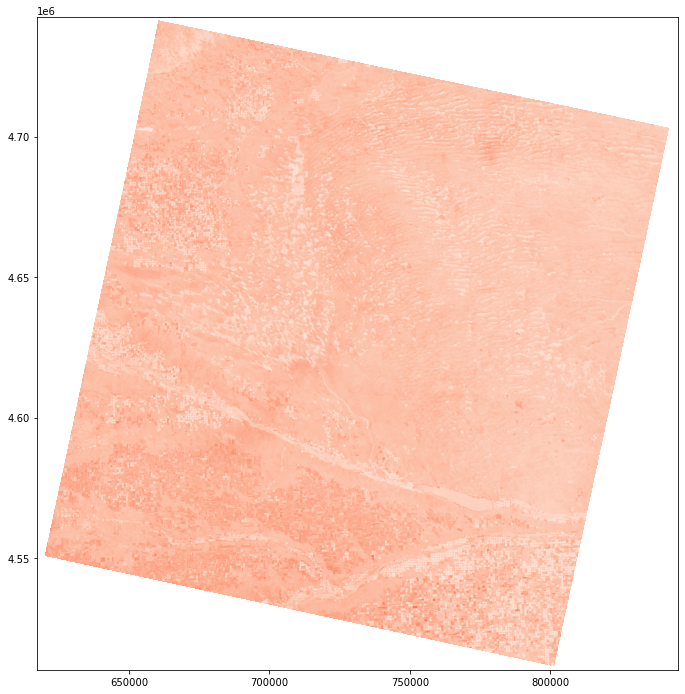

In [11]:
with rio.Env(AWSSession(session, requester_pays=True), 
             AWS_NO_SIGN_REQUEST='NO',
             GDAL_DISABLE_READDIR_ON_OPEN='TRUE'):
    with rio.open(rp_url) as src:
        print(src.profile)
        print(f'Overviews levels: {src.overviews(1)}')
        print(type(src))
            
        fig, ax = plt.subplots(1, figsize=(12, 12))
        show(src, cmap='Reds')

## Direct S3 Bucket Access vs Access via HTTPS

Temperary S3 bucket access credential: https://lpdaac.earthdata.nasa.gov/s3credentials

In [12]:
nasa_hls_s3_url = 's3://lp-prod-protected/HLSS30.015/HLS.S30.T13TGF.2020191T172901.v1.5.B04.tif'

In [13]:
def get_temp_creds():
    temp_creds_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'
    return requests.get(temp_creds_url).json()

In [14]:
temp_creds_req = get_temp_creds()
#temp_creds_req

In [15]:
session = boto3.Session(aws_access_key_id=temp_creds_req['accessKeyId'], 
                        aws_secret_access_key=temp_creds_req['secretAccessKey'],
                        aws_session_token=temp_creds_req['sessionToken'],
                        region_name='us-west-2')

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 4600020.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
Overviews levels: [2, 4, 8, 16]
<class 'rasterio.io.DatasetReader'>


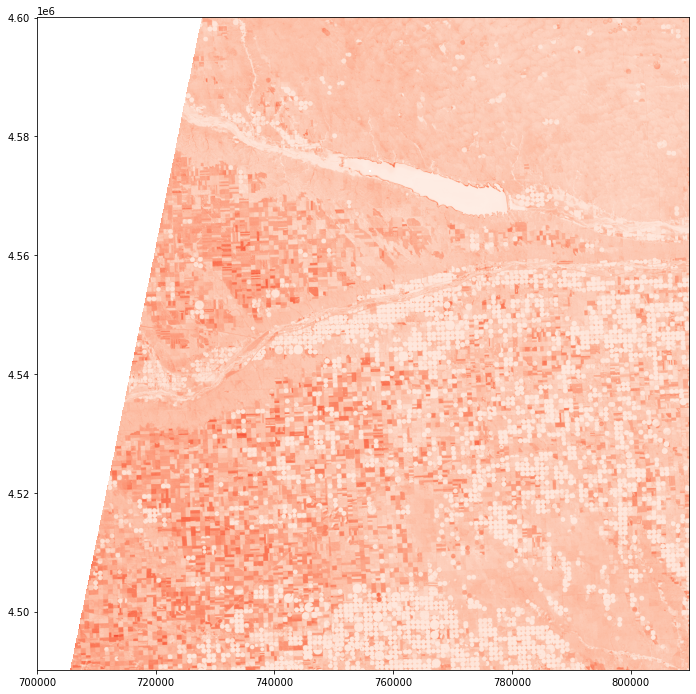

CPU times: user 1.48 s, sys: 187 ms, total: 1.67 s
Wall time: 1.7 s


In [17]:
%%time

with rio.Env(AWSSession(session),
             GDAL_DISABLE_READDIR_ON_OPEN='TRUE',
             CPL_VSIL_CURL_ALLOWED_EXTENSIONS='tif',
             VSI_CACHE=True, 
             region_name='us-west-2'):
    with rio.open(nasa_hls_s3_url, 'r') as src:
        print(src.profile)
        print(f'Overviews levels: {src.overviews(1)}')
        print(type(src))
             
        fig, ax = plt.subplots(1, figsize=(12, 12))
        show(src, cmap='Reds')

The image above is, in fact, the same NASA HLS asset we requested using HTTPS. Notice how much faster the rendering is when direct S3 access is used.

### Using rasterio and rioxarray

All the examples above use `Rasterio` directly to open the cloud assets. This results in a `numpy.ndarray` object. We can also use a package call `rioxarray` to read our cloud assets in as an xarray/dask array object.

**Access via `rioxarray`**

In [18]:
with rio.Env(AWSSession(session), 
             GDAL_DISABLE_READDIR_ON_OPEN='TRUE',
             CPL_VSIL_CURL_ALLOWED_EXTENSIONS='tif',
             VSI_CACHE=True,
             region_name='us-west-2'):
    with rioxarray.open_rasterio(nasa_hls_s3_url) as src:
        ds = src.squeeze('band', drop=True)
        print(ds)

<xarray.DataArray (y: 3660, x: 3660)>
[13395600 values with dtype=int16]
Coordinates:
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.097e+05
  * y            (y) float64 4.6e+06 4.6e+06 4.6e+06 ... 4.49e+06 4.49e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  0.0001
    add_offset:    0.0
    long_name:     Red


Note about context manager/environments 

In [19]:
ds

<xarray.DataArray (y: 3660, x: 3660)>
[13395600 values with dtype=int16]
Coordinates:
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.097e+05
  * y            (y) float64 4.6e+06 4.6e+06 4.6e+06 ... 4.49e+06 4.49e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  0.0001
    add_offset:    0.0
    long_name:     Red

In [20]:
ds.values    # Throws an error...on purpose

Warning 1: HTTP response code on https://lp-prod-protected.s3.amazonaws.com/HLSS30.015/HLS.S30.T13TGF.2020191T172901.v1.5.B04.tif.msk: 403
Warning 1: HTTP response code on https://lp-prod-protected.s3.amazonaws.com/HLSS30.015/HLS.S30.T13TGF.2020191T172901.v1.5.B04.tif.MSK: 403
ERROR 1: Request for 5687029-15703341 failed
ERROR 1: Request for 15826307-15919452 failed
ERROR 1: Request for 16012871-16103508 failed
ERROR 1: Request for 16374400-16557951 failed
ERROR 1: Request for 16793570-16885747 failed
ERROR 1: Request for 5687029-15703341 failed
ERROR 1: Request for 15826307-15919452 failed
ERROR 1: Request for 16012871-16103508 failed
ERROR 1: Request for 16374400-16557951 failed
ERROR 1: Request for 16793570-16885747 failed
ERROR 1: TIFFFillTile:Read error at row 4294967295, col 4294967295, tile 0; got 0 bytes, expected 569
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: /vsis3/lp-prod-protected/HLSS30.015/HLS.S30.T13TGF.2020191T172901.v1.5.B04.tif, band 1: IReadBlock failed at X off

RasterioIOError: Read or write failed. /vsis3/lp-prod-protected/HLSS30.015/HLS.S30.T13TGF.2020191T172901.v1.5.B04.tif, band 1: IReadBlock failed at X offset 0, Y offset 0: TIFFReadEncodedTile() failed.

**Access data value within the `rasterio` environment context manager**

In [22]:
with rio.Env(AWSSession(session), 
             GDAL_DISABLE_READDIR_ON_OPEN='TRUE',
             CPL_VSIL_CURL_ALLOWED_EXTENSIONS='tif',
             VSI_CACHE=True,
             region_name='us-west-2'):
    with rioxarray.open_rasterio(nasa_hls_s3_url) as src:
        ds = src.squeeze('band', drop=True)
        print(ds.values)

[[-9999 -9999 -9999 ...  1214  1161  1208]
 [-9999 -9999 -9999 ...  1122  1171  1170]
 [-9999 -9999 -9999 ...  1096  1124  1063]
 ...
 [-9999 -9999 -9999 ...  1062  1163   876]
 [-9999 -9999 -9999 ...  1052   927   986]
 [-9999 -9999 -9999 ...   867   823   764]]


## Resources

- https://github.com/pangeo-data/cog-best-practices
- https://geohackweek.github.io/raster/04-workingwithrasters/
- https://www.usgs.gov/core-science-systems/nli/landsat/landsat-commercial-cloud-data-access
- https://rasterio.readthedocs.io/en/latest/topics/configuration.html

---

## [Next: Topic 2 - Cloud Optimized Data](Topic_2__Cloud_Optimized_Data.ipynb)